# Example: Cybernetic Portfolio Allocation Performance
This example will familiarize students with cybernetic portfolio allocation (an experimental idea I'm working on). Cybernetic models are goal-oriented decision models that are used in many applications. For portfolio allocation, let's propose that the allocation of asset $a\in\mathcal{P}$ is given by:
$$
\begin{equation*}
    \omega_{i}(\lambda) = \frac{\exp(\mathbb{E}(R_{i})/\beta_{i}^{\lambda})}{\sum_{a\in\mathcal{P}}\exp(\mathbb{E}(R_{a})/\beta_{a}^{\lambda})}\quad\forall{i}\in\mathcal{P}
\end{equation*}
$$
The parameter $\lambda$ is a hyper-parameter, and the risk-adjusted expected excess return for asset $i\in\mathcal{P}$ is given by:
$$
\begin{equation*}
    \mathbb{E}(R_{i})/\beta_{i}^{\lambda} = \alpha_{i}/\beta_{i}^{\lambda} + \beta^{1-\lambda}\cdot\mathbb{E}(R_{m})
\end{equation*}
$$
where $\mathbb{E}(R_{m})$ is the expected excess return of the market factor. This maybe a nutty, idea, so let's check it out!

### Learning tasks and objectives
* __Prerequisites__: Load and clean an out-of-sample dataset to simulate daily rebalancing decisions. We'll load daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until `09-23-24` close, along with data for a few exchange-traded funds and volatility products during that time.
* __Task 1__: Simulate an equally weighted portfolio without rebalancing. In this task, we'll select the tickers in our portfolio $\mathcal{P}$, then simulate an equally weighted portfolio using an out-of-sample dataset.
* __Task 2__: Compute the performance of a cybernetic-weighted portfolio. In this task, we'll implement the cybernetic allocation scheme and explore the role of the various hyper-parameters associated with the approach.

## Setup
We set up the computational environment by including [the `Include.jl` file](Include.jl). The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

[ Info: Precompiling VLQuantitativeFinancePackage [4119e0bf-20d0-4785-913e-5ebdb0caa218] (cache misses: wrong dep version loaded (2), invalid header (6))
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (4), invalid header (8))
[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b] (cache misses: wrong dep version loaded (2), invalid header (4))
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c] (cache misses: wrong dep version loaded (4), invalid header (10))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (4), invalid header (10))
[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd] (cache misses: wrong dep version loaded (2), invalid header (6))
[ Info: Precompiling ForwardDiffStaticArraysExt [b74fd6d0-9da7-541f-a07d-1b6af30a262f] (cache misses: wrong dep version loaded (2), invalid header (4))


## Prerequisites: Load and clean the testing dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until last week `09-23-24` close, along with data for a few exchange-traded funds and volatility products during that time. We load the `out_of_sample_dataset::Dict{String, DataFrame}` by calling the `MyOutOfSampleMarketDataSet()` function:

In [5]:
out_of_sample_dataset = MyOutOfSampleMarketDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 488 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  "BBWI" => 182×8 DataFrame…
  "CAG"  => 182×8 DataFrame…
  "GPC"  => 182×8 DataFrame…
  "FCX"  => 182×8 DataFrame…
  "GILD" => 182×8 DataFrame…
  "UNP"  => 182×8 DataFrame…
  ⋮      => ⋮

Now, let's get the number of trading days of data that we have to experiment with. 

In [7]:
number_of_trading_days = out_of_sample_dataset["AAPL"] |> nrow; # max number of days, you can reset for shorter durations

### Load single index models and compute the covariance
Previously, we estimated the parameters and residual distributions for each `ticker` and saved these to a [JLD2.jl file](https://github.com/JuliaIO/JLD2.jl). Load this file using the [load(...) function](https://juliaio.github.io/JLD2.jl/stable/#save-and-load-functions). 
* Store the model collection in the `sim_model_dictionary` variable, where the keys of the dictionary are the ticker symbols and the values are the parameterized [MySingleIndexModel instances](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MySingleIndexModel) estimated previously.

In [9]:
sim_model_dictionary = load(joinpath(_PATH_TO_DATA, "SIMs-SP500-01-03-18-to-12-29-23.jld2")) |> x->x["sim"]

Dict{String, MySingleIndexModel} with 460 entries:
  "NI"   => MySingleIndexModel(-0.0671224, 0.652999, 0.0389, Normal{Float64}(μ=…
  "EMR"  => MySingleIndexModel(-0.0549877, 1.23526, 0.0389, Normal{Float64}(μ=-…
  "CTAS" => MySingleIndexModel(0.119417, 1.17936, 0.0389, Normal{Float64}(μ=-6.…
  "HSIC" => MySingleIndexModel(-0.0811194, 0.913675, 0.0389, Normal{Float64}(μ=…
  "KIM"  => MySingleIndexModel(-0.0818621, 1.28859, 0.0389, Normal{Float64}(μ=-…
  "PLD"  => MySingleIndexModel(0.0273092, 1.02836, 0.0389, Normal{Float64}(μ=1.…
  "IEX"  => MySingleIndexModel(-0.00940007, 0.963259, 0.0389, Normal{Float64}(μ…
  "BAC"  => MySingleIndexModel(-0.0922207, 1.32778, 0.0389, Normal{Float64}(μ=-…
  "CBOE" => MySingleIndexModel(-0.00982405, 0.588498, 0.0389, Normal{Float64}(μ…
  "EXR"  => MySingleIndexModel(0.0252878, 0.725388, 0.0389, Normal{Float64}(μ=3…
  "NCLH" => MySingleIndexModel(-0.336719, 2.32891, 0.0389, Normal{Float64}(μ=1.…
  "CVS"  => MySingleIndexModel(-0.0703279, 0.78292, 0.0389

Next, let's build a sorted list of firms that we have in cleaned up `sim_model_dictionary::Dict{String, MySingleIndexModel}` and save it in the `list_of_all_tickers::Array{String,1}` array:

In [11]:
list_of_all_tickers = keys(sim_model_dictionary) |> collect |> sort;

Set some constants. Since we don't have access to historical data in this case study, we'll estimate some parameters from other sources or set typical values.

In [13]:
σₘ = 0.1621; # implied volatility for SPY
μₘ = 0.10; # assumed historical expected excess return for SPY
risk_free_rate = 0.0389; # hypothetical continuous compounded risk-free rate (units: 1/year)
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)
my_total_budget = 1000.0; # investment budget
ϵ = 0.05; # risk tolerance
startdate = Date(2024,01,03); # We will start our portfolio at the close of this day

### Alternative investment
In this study, we'll use `SPY` as a hypothetical alternative investment, i.e., we'll invest our budget $\mathcal{B}$ in in `SPY` instead of our portfolio $\mathcal{P}$. Toward this, let's compute the number of shares of `SPY` to purchase, which we store in the `n_spy::Float64` variable, and capture the close price of `SPY` in the `S_spy::Array{Float64,1}` array.

In [15]:
(n_spy, S_spy) = let
    price_df = out_of_sample_dataset["SPY"];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
    nᵢ = (my_total_budget)/startprice;
    S = price_df[1:end,:close];
    nᵢ,S
end;

In [16]:
SPY_excess_return_array = log_growth_matrix(out_of_sample_dataset, ["SPY"], 
    Δt = Δt, risk_free_rate = risk_free_rate); # one-trading day Δt, get SPY excess return

## Task 1:  Simulate Equally Weighted Portfolio Allocation without Reallocation
In this task, we'll select the tickers in our portfolio $\mathcal{P}$, then simulate an (initially) equally weighted portfolio using an out-of-sample dataset. We begin by computing the number of shares of each asset in our portfolio; then, we run the simulation using the out-of-sample dataset.

Let's specify a list of `N::Int64` tickers in the `my_list_of_tickers::Array{String,1}` array to get started. The tickers we select must be in the `sim_model_dictionary::Dict{String, MySingleIndexModel}` dictionary:

In [18]:
my_list_of_tickers = ["AAPL", "MSFT", "NVDA", "MU", "AMD", "JNJ", "PG", "MRK", "PFE", "GS", "WFC", "JPM"]; # specify tickers
N = length(my_list_of_tickers); # number of assets in the portfolio 

### Lookup the initial share prices
Next, get the share price at the close of the market on `startdate::Date` for each asset in the portfolio. We'll store these values in the `Sₒ::Array{Float64,1}` array (and use them to calculate our initial allocation):

In [20]:
Sₒ = let
    Sₒ = Array{Float64,1}()
    for ticker ∈ my_list_of_tickers
        price_df = out_of_sample_dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
        push!(Sₒ,startprice)
    end
    Sₒ;
end;

`Unhide` the code block below to see how we make a table that shows the initial share prices (at market close) for each `ticker` $\in$ `my_list_of_tickers` on the first day of hypothetical trading specified by `startdate::Date`

In [22]:
let
    df = DataFrame()
    for ticker ∈ my_list_of_tickers
        price_df = out_of_sample_dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
        row_df = (
            date = startdate,
            ticker = ticker,
            initial_share_price = startprice
        );
        push!(df, row_df);
    end
    pretty_table(df, tf=tf_simple)
end

============= ======== ======================
        date   ticker   initial_share_price 
        Date   String               Float64 
============= ======== ======================
  2024-01-03     AAPL                184.25
  2024-01-03     MSFT                 370.6
  2024-01-03     NVDA                47.569
  2024-01-03       MU                 82.26
  2024-01-03       BA                243.91
  2024-01-03      JNJ                160.97
  2024-01-03       PG                147.84
  2024-01-03      MRK                114.77
  2024-01-03      PFE                 29.73
  2024-01-03       GS                381.79
  2024-01-03      WFC                 48.68
  2024-01-03      JPM                171.33
============= ======== ======================


### Compute the initial number of shares
Now that we have the initial prices, we can compute the number of shares of each asset that corresponds to the desired allocation and store these values in the `Nₒ::Array{Float64,1}` variable (in this case, we allow for fractional shares). The initial number of shares is given by:
$$
n_{a} = \frac{\mathcal{B}\cdot\omega_{a}}{S_{\circ,a}}\quad\forall{a}\in\mathcal{P}
$$
where $\mathcal{B}$ is the inital investment budget, $S_{\circ,a}$ is the initial share price for asset $a$, and $\omega_{a}$ denotes the allocation fraction for asset $a$. In this case, we have an equal partition, so $\omega_{a} = 1/N$ where $N$ is the number of assets in the portfolio. 

Compute the initial number of shares, which we store in the `Nₒ::Array{Float64,1}` array:

In [24]:
Nₒ = let
    Nₒ = Array{Float64,1}()
    for i ∈ eachindex(my_list_of_tickers)
        
        wᵢ = 1/N; # equal weight allocation
        nᵢ = (wᵢ*my_total_budget)/Sₒ[i];
        push!(Nₒ,nᵢ)
    end
    Nₒ
end;

`Unhide` the code block below to see how we made an initial allocation table for the fixed equally weighted portfolio. 
* The column `ticker` holds the firms in our portfolio, the column `n` is the number of shares that we purchased near market close on `startdate::Date,` the `initial_share_price` column is the price per share of each ticker, the `value` column holds the cash (liquidation) value of each position at market close on `startdate::Date` and the `w` column holds the asset weight:

In [26]:
let
    df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i]; # get the ticker
        value = Nₒ[i]*Sₒ[i];

        row_df = (
            ticker = ticker,
            n = Nₒ[i],
            initial_share_price = Sₒ[i],
            value = value,
            w = 1/N
        )
        push!(df, row_df);
    end

    footer = (
        ticker = "total",
        n = sum(Nₒ),
        initial_share_price = 0,
        value = sum(Nₒ.*Sₒ),
        w = sum(df[1:end,:w])
    )
    push!(df, footer)
    pretty_table(df, tf=tf_simple)   
end

========= ========== ===================== ========= ============
  ticker          n   initial_share_price     value           w 
  String    Float64               Float64   Float64     Float64 
========= ========== ===================== ========= ============
    AAPL   0.452284                184.25   83.3333   0.0833333
    MSFT   0.224861                 370.6   83.3333   0.0833333
    NVDA    1.75184                47.569   83.3333   0.0833333
      MU    1.01305                 82.26   83.3333   0.0833333
      BA   0.341656                243.91   83.3333   0.0833333
     JNJ   0.517695                160.97   83.3333   0.0833333
      PG   0.563672                147.84   83.3333   0.0833333
     MRK    0.72609                114.77   83.3333   0.0833333
     PFE      2.803                 29.73   83.3333   0.0833333
      GS    0.21827                381.79   83.3333   0.0833333
     WFC    1.71186                 48.68   83.3333   0.0833333
     JPM   0.486391               

### What is the initial $\beta_{\mathcal{P}}$?
We'll use the relative portfolio risk $\beta_{\mathcal{P}}$ as our decision metric, i.e., we'll monitor changes in the riskiness of the portfolio. If the risk changes beyond a threshold, we will reallocate the portfolio. This value is given by (for an equally weighted portfolio):
$$
\beta_{\mathcal{P}} = \frac{1}{N}\sum_{a\in\mathcal{P}}\beta_{a}
$$
where $N$ is the number of assets in the portfolio $\mathcal{P}$ and $\beta_{a}$ denotes the the single index parameter for asset $a\in\mathcal{P}$. In this scheme, the relative portfolio risk $\beta_{\mathcal{P}}$ is the average risk of the assets in the portfolio as measured by the $\beta_{a}$ parameters.
* In the code below, we initialize a value for `β = 0`, set the allocation fraction $\omega_{i} = 1/N$, and then process each ticker in the portfolio, where we look up the single index model parameters from the `sim_model_dictionary::Dict{String, MySingleIndexModel}` dictionary. we compute the sum [using the short cut `+=` operator](https://docs.julialang.org/en/v1/manual/mathematical-operations/) 

In [28]:
β = let

    β = 0.0; # initialize to zero
    wᵢ = 1/N; # equally weighted portfolio
    for ticker ∈ my_list_of_tickers # this is iterating over the tickers *directly*
        βᵢ = sim_model_dictionary[ticker].β;
        β += wᵢ*βᵢ # equiv to: β = β + wᵢ*βᵢ
    end
    β
end
println("The overall β for the portfolio: $(β)")

The overall β for the portfolio: 1.1003457010842141


### Fixed Equally Weighted Simulation
`Unhide` the code block to see how we simulated the performance of the equally weighted portfolio starting from `startdate::Date` and ending on the last day of data available in the out-of-sample dataset.
* __What's the story with the `let` block__? A [let block](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Let-Blocks) creates a new hard scope and introduces new variable bindings each time they run. Thus, they act like a private scratch space, where data comes in (is captured by the block), but only what we want to be exposed comes out. In this case, we want the block to export the wealth, allocation, and beta arrays.
* The `wealth_array_fixed::Array{Float64,2}` array holds the wealth (liquidation value) of each asset $a\in\mathcal{P}$, and the total value in the last column. Each row of the `wealth_array_fixed::Array{Float64,2}` array holds a trading period. Similarly, the `omega_array_fixed::Array{Float64,2}` array holds the allocations (the last column is the total), and `beta_array_fixed::Array{Float64,2}` holds the $\beta_{\mathcal{P}}$ values.
* __Assumption__: We are using $\beta_{i}$ values estimated using historical data; we'll assume these values are not changing over the course of the simulation. 

In [30]:
(wealth_array_fixed, omega_array_fixed, beta_array_fixed) = let

    wealth_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col is the total
    omega_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col if the total
    beta_array = Array{Float64,1}(undef, number_of_trading_days - 1);
    for i = 1:(number_of_trading_days - 1)

        # get the close price array -
        close_price_array = market(out_of_sample_dataset, my_list_of_tickers, i); # gets the close price for today
        
        # compute the wealth array -
        for j ∈ eachindex(my_list_of_tickers)
           wealth_array[i,j] = Nₒ[j]*close_price_array[j];
        end
        wealth_array[i,end] = sum(wealth_array[i,1:end-1]);

        # compute the omega array -
        for j ∈ eachindex(my_list_of_tickers)
            omega_array[i,j] = wealth_array[i,j]/(wealth_array[i,end])
        end
        omega_array[i,end] = sum(omega_array[i,1:end-1]);

        # compute beta -
        beta = 0.0
        for j ∈ eachindex(my_list_of_tickers)
            ticker = my_list_of_tickers[j];
            βᵢ = sim_model_dictionary[ticker].β;
            beta += omega_array[i,j]*βᵢ;
        end
        beta_array[i] = beta;
        
    end
    wealth_array,omega_array,beta_array
end;

#### Visualize
`Unhide` the code block below to see how we plotted the `wealth_array_fixed::Array{Float64,2}` array corresponding to the fixed equally weighted portfolio and the alternative investment for the out-of-sample dataset.
* __Summary__: The horizontal axis is the trading day index, while the vertical axis is the total liquidation value of the portfolio $\mathcal{P}$ or the alternative investment. The blue line shows the value of your equally weighted portfolio, while the red line shows the value of the alternative investment, in this case, `SPY.` Depending upon your choice of tickers in portfolio $\mathcal{P}$, you may (or may not) outperform `SPY` over the course of the out-of-sample dataset.

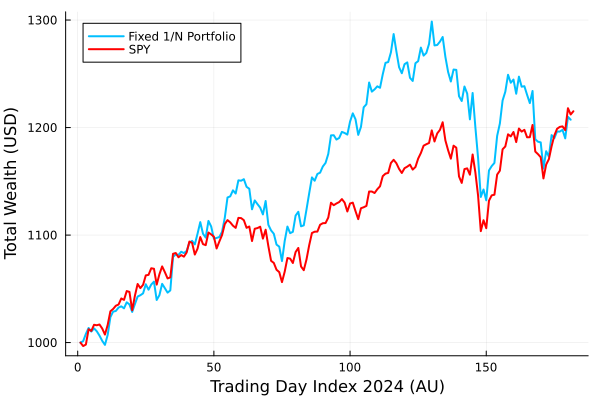

In [32]:
let
    plot(wealth_array_fixed[1:(number_of_trading_days - 1),end], lw=2, c=:deepskyblue1, label="Fixed 1/N Portfolio")
    plot!(n_spy*S_spy, c=:red, lw=2, label="SPY")
    xlabel!("Trading Day Index 2024 (AU)", fontsize=18);
    ylabel!("Total Wealth (USD)", fontsize=18)
end

## Task 2: Compute the performance of a cybernetic weighted portfolio
In this task, we'll implement the cybernetic allocation scheme and explore the role of the various hyper-parameters associated with the approach. The first hyper-parameter we set is $\lambda$, the exponent on the risk adjustment for the expected return expression. We set this in the `λ::Float64` variable:

In [34]:
λ = 1.5; # exponent for the risk weighting

Next, we'll compute the initial cybernetic allocation, the initial portfolio relative risk, and the number of shares of $a\in\mathcal{P}$. Initially, we'll use the historical long-run average for the expected excess return of the market factor, i.e., `SPY` in our case (specified above), to compute the risk-adjusted expected excess returns for each asset in the portfolio. 

In [36]:
w_initial_cybernetic, β_cybernetic, n_cybernetic = let

    # initialize -
    ωᵢ = Array{Float64,1}(undef, N);
    nᵢ = Array{Float64,1}(undef, N);
    β = 0.0;
    
    # compute the initial cybernetic allocation
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        αᵢ = sim_model_dictionary[ticker].α;
        βᵢ = sim_model_dictionary[ticker].β;
        expected_return_value = (αᵢ/(βᵢ^λ)) + (βᵢ^(1-λ))*μₘ
        ωᵢ[i] = exp(expected_return_value)
    end
    Z = sum(ωᵢ);
    ωᵢ = (1/Z)*ωᵢ;

    # compute the initial number of shares
    for i ∈ eachindex(my_list_of_tickers)
       nᵢ[i] = (ωᵢ[i]*my_total_budget)/Sₒ[i]
    end

    # compute the beta for the cybernetic portfolio
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        βᵢ = sim_model_dictionary[ticker].β;
        β += ωᵢ[i]*βᵢ # equiv to: β = β + wᵢ*βᵢ
    end

    # return
    ωᵢ,β,nᵢ
end;
println("The overall β for the cybernetic portfolio: $(β_cybernetic)")

The overall β for the cybernetic portfolio: 1.098274496147556


`Unhide` the code block below to see how we made an initial cybernetic allocation table. 
* The column `ticker` holds the firms in our portfolio, the column `n` is the number of shares that we purchased near market close on `startdate::Date,` the `initial_share_price` column is the price per share of each ticker, and the `value` column holds the cash (liquidation) value of each position at market close on `startdate::Date.` The `w` column holds the allocation fraction, while the $\alpha,\beta$ columns hold the single index model parameters (historical).

In [38]:
let
    df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i]; # get the ticker
        value = n_cybernetic[i]*Sₒ[i];

        row_df = (
            ticker = ticker,
            n = n_cybernetic[i],
            initial_share_price = Sₒ[i],
            value = value,
            w = w_initial_cybernetic[i],
            alpha = sim_model_dictionary[ticker].α,
            beta = sim_model_dictionary[ticker].β
        )
        push!(df, row_df);
    end

    # compute 
    
    footer = (
        ticker = "total",
        n = sum(Nₒ),
        initial_share_price = 0,
        value = sum(n_cybernetic.*Sₒ),
        w = sum(df[1:end,:w]),
        alpha = 0,
        beta = β_cybernetic
    )
    push!(df, footer)
    
    pretty_table(df, tf=tf_simple)   
end

========= ========== ===================== ========= =========== ============ ===========
  ticker          n   initial_share_price     value           w        alpha       beta 
  String    Float64               Float64   Float64     Float64      Float64    Float64 
========= ========== ===================== ========= =========== ============ ===========
    AAPL   0.496931                184.25   91.5596   0.0915596     0.141635    1.24019
    MSFT   0.252249                 370.6   93.4837   0.0934837      0.14394    1.13379
    NVDA    1.88962                47.569   89.8873   0.0898873     0.237071    1.78828
      MU   0.987735                 82.26   81.2511   0.0812511   -0.0151433    1.52694
      BA    0.31158                243.91   75.9974   0.0759974    -0.152749    1.65663
     JNJ   0.473886                160.97   76.2814   0.0762814   -0.0508769   0.548523
      PG   0.609315                147.84   90.0811   0.0900811    0.0129575   0.508097
     MRK   0.856446       

### Cybernetic Portfolio Simulation
`Unhide` the code block to see how we simulated the performance of the equally weighted portfolio starting from `startdate::Date` and ending on the last day of data available in the out-of-sample dataset.
* __What's the story with the `let` block__? A [let block](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Let-Blocks) creates a new hard scope and introduces new variable bindings each time they run. Thus, they act like a private scratch space, where data comes in (is captured by the block), but only what we want to be exposed comes out. In this case, we want the block to export the wealth, allocation, and beta arrays.
* The `wealth_array_fixed::Array{Float64,2}` array holds the wealth (liquidation value) of each asset $a\in\mathcal{P}$, and the total value in the last column. Each row of the `wealth_array_fixed::Array{Float64,2}` array holds a trading period. Similarly, the `omega_array_fixed::Array{Float64,2}` array holds the allocations (the last column is the total), and `beta_array_fixed::Array{Float64,2}` holds the $\beta_{\mathcal{P}}$ values.
* __Assumption__: We are using $\beta_{i}$ values estimated using historical data; we'll assume these values are not changing over the course of the simulation. 

The cybernetic simulation requires a few parameters; let's specify those here. Chek out the comment next to the parameter for its meaning, permissible values, etc.

In [41]:
α̂ = 0.05; # learning rate for the expected excess market return
τ = 252; # force a rebalance at multiples of this value

In [42]:
(wealth_array_cybernetic, omega_array_cybernetic, beta_array_cybernetic, avg_spy_array) = let

    wealth_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col is the total
    omega_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col if the total
    beta_array = Array{Float64,1}(undef, number_of_trading_days - 1);
    avg_spy_array = Array{Float64,1}(undef,number_of_trading_days - 1);

    avg_spy_array[1] = μₘ; 
    Nᵢ = copy(n_cybernetic);
    ωᵢ = copy(w_initial_cybernetic);
    
    for i = 1:(number_of_trading_days - 1)
        
        # --- TODAY ----------------------------------------------------------------------------------------------- #
        close_price_array = market(out_of_sample_dataset, my_list_of_tickers, i); # gets the close price for today

        # update the expected value for SPY
        if (i ≥ 2)
            tmp = (1/Δt)*log(S_spy[i]/S_spy[i-1]);
            avg_spy_array[i] = avg_spy_array[i-1] + α̂*(tmp - avg_spy_array[i-1]);
        end

        # compute the wealth array -
        for j ∈ eachindex(my_list_of_tickers)
           wealth_array[i,j] = Nᵢ[j]*close_price_array[j];
        end
        wealth_array[i,end] = sum(wealth_array[i,1:end-1]); # liquidate at close 

        # copy the allocation into the omega_array -
        for j ∈ eachindex(my_list_of_tickers)
            omega_array[i,j] = ωᵢ[j];
        end
        omega_array[i,end] = sum(omega_array[i,1:end-1]);

        # compute realized beta -
        beta = 0.0
        for j ∈ eachindex(my_list_of_tickers)
            ticker = my_list_of_tickers[j];
            βᵢ = sim_model_dictionary[ticker].β;
            beta += (wealth_array[i,j]/wealth_array[i,end])*βᵢ; # beta that we actually see
        end
        beta_array[i] = beta;
        # -------------------------------------------------------------------------------------------------------- #

        
        # --- AT OPEN NEXT DAY ----------------------------------------------------------------------------------- #
        if (abs(beta - β_cybernetic) ≥ ϵ || mod(i,τ) == 0) # compare beta that we see, to beta we want

            my_new_total_budget = wealth_array[i,end]; # budget (liquidate at close, yesterday)
            next_price_array = market(out_of_sample_dataset, my_list_of_tickers, i + 1, key = :open); # reallocate at open this morning

            tmp = Array{Float64,1}(undef, N);
            for j ∈ eachindex(my_list_of_tickers)
                ticker = my_list_of_tickers[j];
                αᵢ = sim_model_dictionary[ticker].α;
                βᵢ = sim_model_dictionary[ticker].β;
                tmp[j] = ((αᵢ/(βᵢ^λ)) + (βᵢ^(1-λ))*avg_spy_array[i]) |> x-> exp(x); 
            end
            Z = sum(tmp);
            for j ∈ eachindex(my_list_of_tickers)
                ωᵢ[j] = (1/Z)*tmp[j]; # update the allocations
            end
        
            # compute the new number of shares -
            for j ∈ eachindex(my_list_of_tickers)
                Nᵢ[j] = (ωᵢ[j]*my_new_total_budget)/next_price_array[j]; # reallocate
            end
        end
        # -------------------------------------------------------------------------------------------------------- #
        
    end

    wealth_array,omega_array,beta_array,avg_spy_array
end;

#### Visualize: What $\mathbb{E}(R_{m})$ does the cybernetic model see?
The cybernetic model uses a moving average of the expected excess market return $\mathbb{E}(R_{m})$, along with single index models, to compute the allocation. Let's look at this moving average relative to the instantaneous expected excess return.
* `Unhide` the code block below to see how we plotted the expected excess market return. The blue line is the observed excess `SPY` growth (scaled return), while the red line is the moving average used by the cybernetic allocation model.

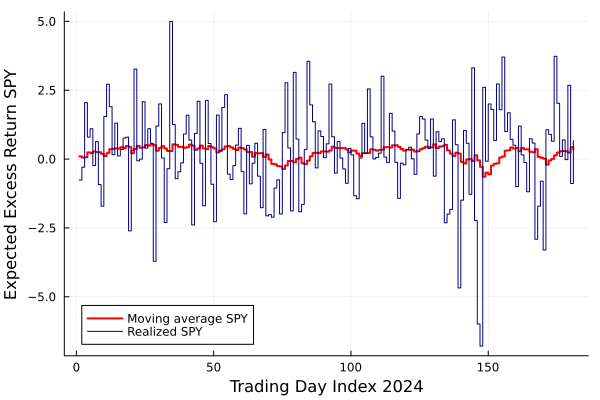

In [44]:
let
    plot(avg_spy_array, c=:red, lw=2, linetype=:steppost, label="Moving average SPY")
    plot!(SPY_excess_return_array, c=:navy, lw=1, linetype=:steppost, label="Realized SPY")
    xlabel!("Trading Day Index 2024", fontsize=18)
    ylabel!("Expected Excess Return SPY", fontsize=18);
end

#### Visualize: What is the cybernetic model risk behavior
`Unihide` the code block below to see how we plotted the relative risk for the portfolio $\mathcal{P}$ for each period in the out-of-sample dataset in the presence of rebalancing.
* __Summary__: The horizontal axis is the trading day index, while the vertical axis holds the portfolio relative risk parameter $\beta_{\mathcal{P}}$. The blue line denotes the realized portfolio risk computed at the close of each trading period, while the gray line denotes the initial risk value. The gray region represents the $\pm\,\epsilon$ region around the initial portfolio risk. In the presence of rebalancing, the realized portfolio risk is much closer to the desired risk zone (gray area).

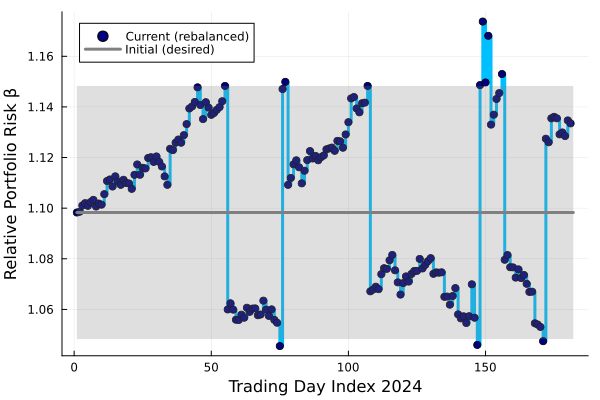

In [46]:
let
    LINE = β_cybernetic*ones(number_of_trading_days);
    U = LINE .+ ϵ;
    L = LINE .- ϵ;
    
    plot(beta_array_cybernetic, c=:deepskyblue1, lw=3, linetype=:steppost, label="")
    scatter!(beta_array_cybernetic, c=:navy, label="Current (rebalanced)")
    plot!(LINE, fillrange=U, c=:gray, fillalpha=0.25, label="")
    plot!(LINE, fillrange=L, c=:gray, fillalpha=0.25, label="")
    plot!(LINE, c=:gray, lw=3, label="Initial (desired)")
    xlabel!("Trading Day Index 2024", fontsize=18)
    ylabel!("Relative Portfolio Risk β", fontsize=18);
end

#### Visualize: What is the cybernetic model performance?
`Unhide` the code block below to see how we plotted the wealth for the equally weighted, cybernetic, and alternative investment for the out-of-sample dataset.
* __Summary__: The horizontal axis is the trading day index, while the vertical axis is the total liquidation value of the portfolio $\mathcal{P}$ with and without rebalancing or the alternative investment. The light blue line shows the value of the equally weighted portfolio without rebalancing, the dark blue line shows the cybernetic case, and the red line shows the value of the alternative investment, in this case, `SPY.`
* Depending upon the choice of tickers in the portfolio, the fixed and cybernetic portfolios may (or may not) outperform `SPY.`

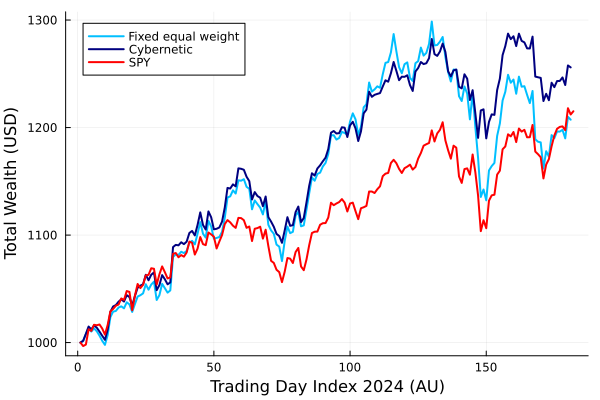

In [48]:
let
    plot(wealth_array_fixed[:,end], lw=2, c=:deepskyblue1, label="Fixed equal weight")
    plot!(wealth_array_cybernetic[:,end], lw=2, c=:navy, label="Cybernetic")
    plot!(n_spy*S_spy, c=:red, lw=2, label="SPY")
    xlabel!("Trading Day Index 2024 (AU)", fontsize=18);
    ylabel!("Total Wealth (USD)", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.